# Tissue Segmentation from membrane marker images

Cell segmentation from images showing membranes can be challenging, e.g. as some markers do not mark membranes continously. Thus, some pre-processing needs to be done in order to retrieve optimal segmentation results.

To demonstrate the workflow, we're using single slices derived from 3D image data from the Broad Bio Image Challenge, _Thirstrup et al. 2018, available from the Broad Bioimage Benchmark Collection, Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637_ (__doi. PMID:__ 22743765 __PMCID:__ PMC3627348). Available at http://dx.doi.org/10.1038/nmeth.2083

In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pyclesperanto as cle

cle.select_device(1, "gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.274.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

We start by loading the image to the device memory, and run a first segmentation using basic thresholding to see how good it can be done right away.

In [2]:
image = imread("../data/BBBC034_v1_dataset/AICS_12_134_C=0.tif")

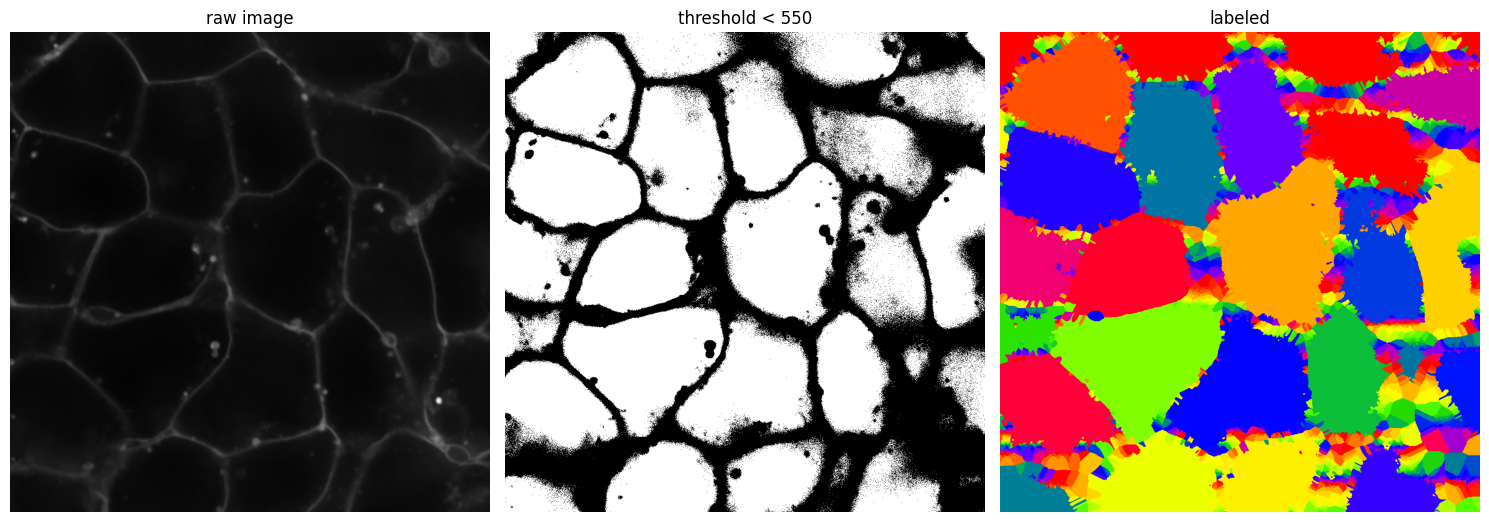

In [3]:
threshold = 550
binary = cle.smaller_constant(image, scalar=threshold)
labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("raw image")
axs[1].imshow(binary, cmap='gray')
axs[1].set_title(f"threshold < {threshold}")
axs[2].imshow(labels, cmap='prism')
axs[2].set_title("labeled")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

We manage to segment and label the well defined cell from their membrane but we can observe an oversegmentation where the signal is not well defined or where the membrane are too thick.

To improve it, we can apply some intermediate correction, e.g. binary opening to improve the segmentation quality in the binary image before labeling individual objects.

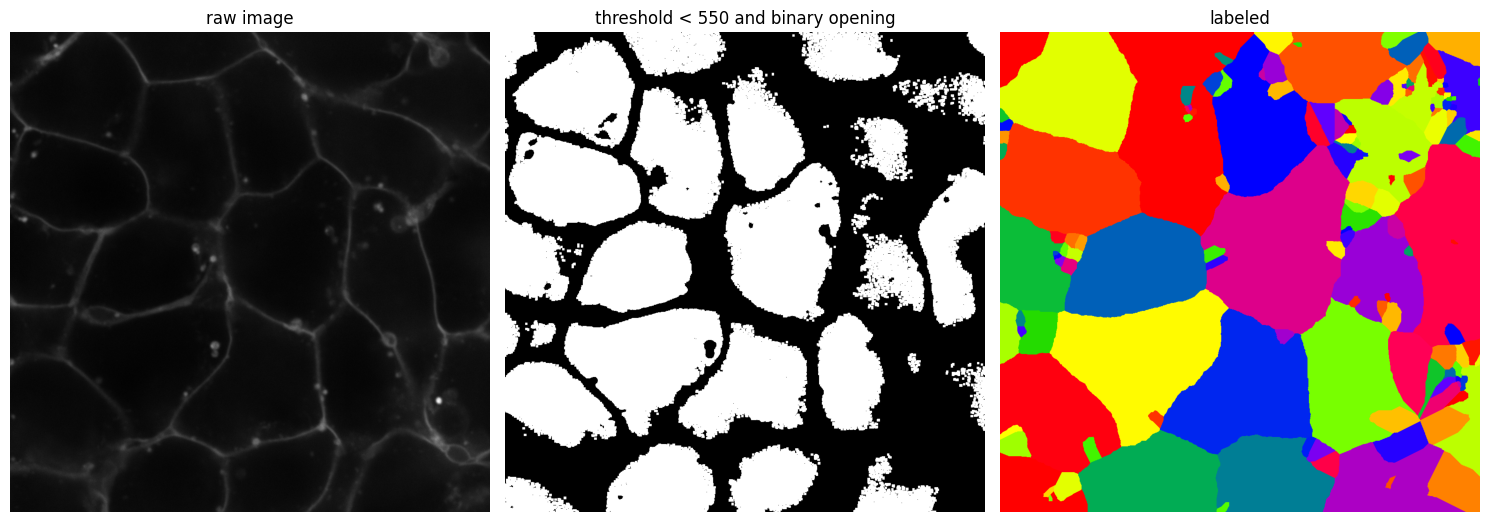

In [4]:
binary = cle.smaller_constant(image, scalar=threshold)
corrected_binary = cle.binary_opening(binary, radius_x=2, radius_y=2)
labels = cle.voronoi_labeling(corrected_binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("raw image")
axs[1].imshow(corrected_binary, cmap='gray')
axs[1].set_title(f"threshold < {threshold} and binary opening")
axs[2].imshow(labels, cmap='prism')
axs[2].set_title("labeled")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

A similar approach can also be done but directly on the intensity image before the threhsolding to improve the membrane thickness and definition (see [edge detection and enhancement](./edge_detect_and_enhancement.ipynb))

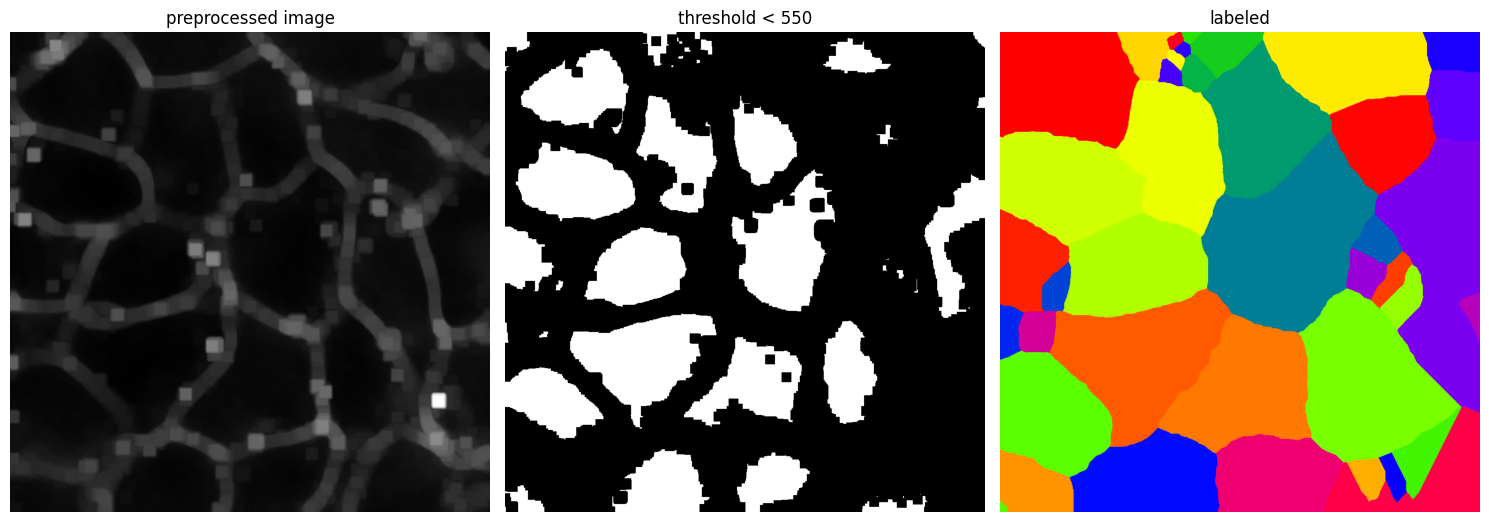

In [5]:
thicker_membranes = cle.grayscale_dilate(image, radius_x=10, radius_y=10, connectivity="box")
binary = cle.smaller_constant(thicker_membranes, scalar=threshold)
labels = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(thicker_membranes, cmap="gray")
axs[0].set_title("preprocessed image")
axs[1].imshow(binary, cmap='gray')
axs[1].set_title(f"threshold < {threshold}")
axs[2].imshow(labels, cmap='prism')
axs[2].set_title("labeled")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

Finally, it is also possible to filter the labels on their size, e.g. removing small label which would not correspond to any valid segmentation in our image.

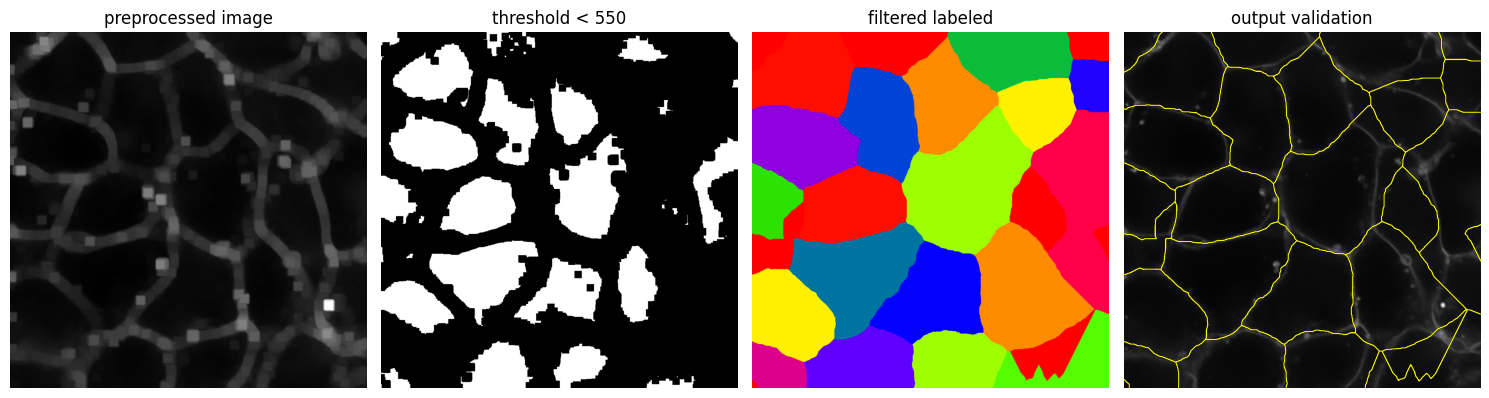

In [6]:
filtered_labels = cle.remove_small_labels(labels, minimum_size=10000)
edges = cle.detect_label_edges(filtered_labels)


fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(thicker_membranes, cmap="gray")
axs[0].set_title("preprocessed image")
axs[1].imshow(binary, cmap='gray')
axs[1].set_title(f"threshold < {threshold}")
axs[2].imshow(filtered_labels, cmap='prism')
axs[2].set_title("filtered labeled")
axs[3].imshow(image, cmap='gray')
axs[3].imshow(cle.binary_dilate(edges, radius_x=1, radius_y=1).get(), cmap=ListedColormap(["none", "yellow"]))
axs[3].set_title("output validation")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

We managed to obtain a nice and smooth labeled segmentation however, we can observe that the precision is not good. This is mainly due to the initial approach of segmentation using basic threshold.

We can also introduce a advance filter like a ridge detector (see [ridge detection](./ridge_detection.ipynb)) to improve membrane detection and standardize the thresholing value and improve the results.

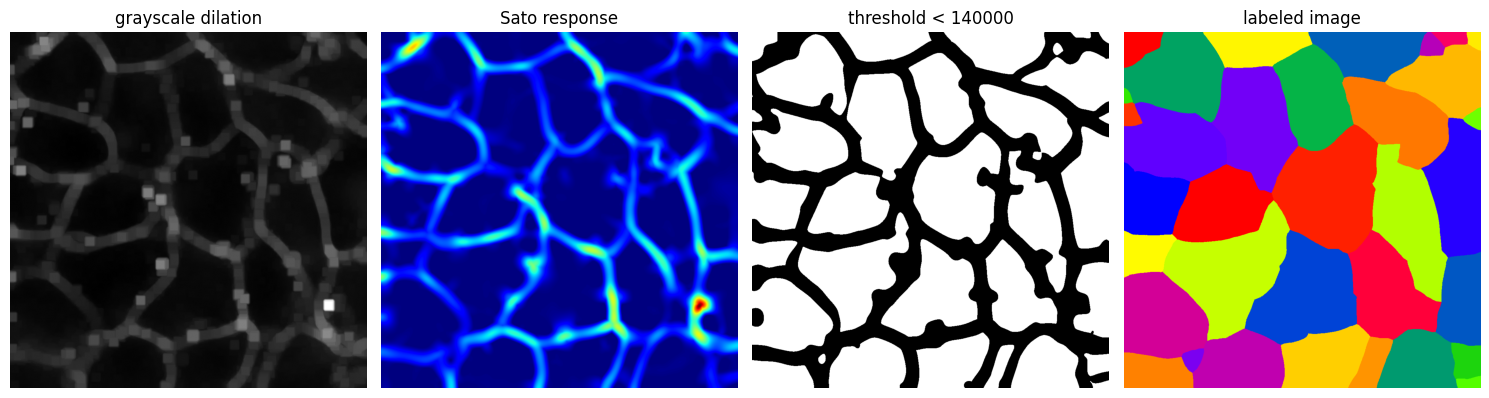

In [9]:
threshold = 140000
image = imread("../data/BBBC034_v1_dataset/AICS_12_134_C=0.tif").astype(float)
thicker_membranes = cle.grayscale_dilate(image, radius_x=10, radius_y=10, connectivity="box")
ridge = cle.sato_filter(thicker_membranes, sigma_minimum=1, sigma_maximum=20)
binary = cle.absolute(ridge - ridge.max()) > threshold
labeled = cle.voronoi_labeling(binary)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(thicker_membranes, cmap='gray')
axs[0].set_title("grayscale dilation")
axs[1].imshow(ridge, cmap="jet")
axs[1].set_title("Sato response")
axs[2].imshow(binary, cmap='gray')
axs[2].set_title(f"threshold < {threshold}")
axs[3].imshow(labeled, cmap='prism')
axs[3].set_title("labeled image")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

Plotted as a final result ...

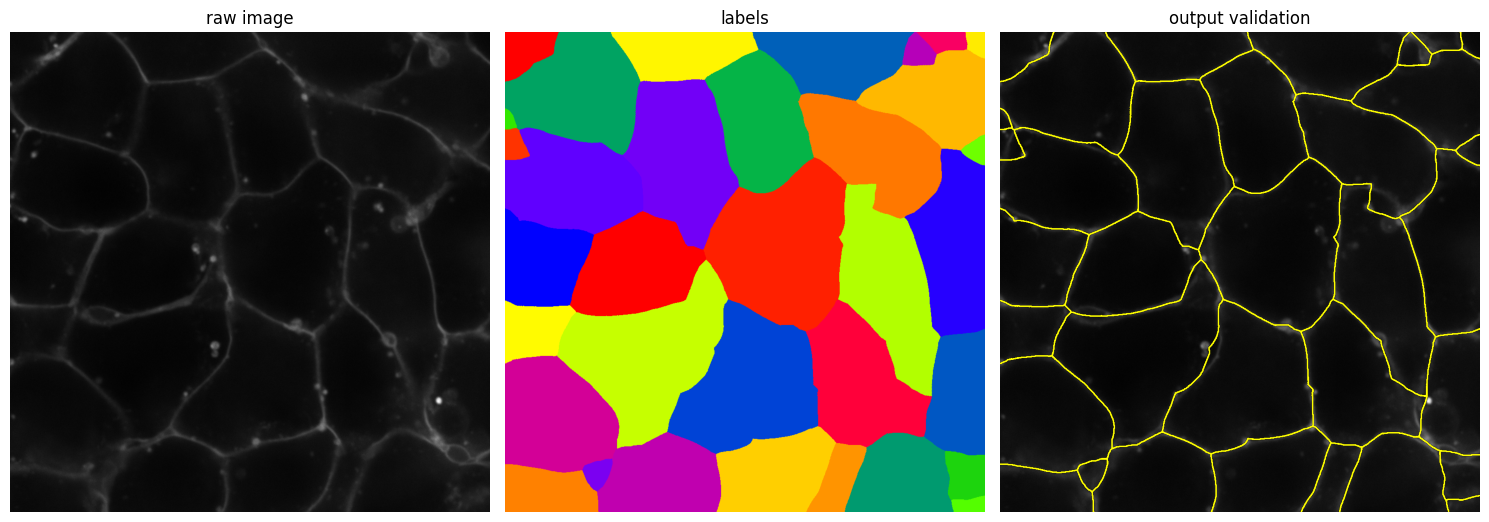

In [8]:
edges = cle.binary_dilate(cle.detect_label_edges(labeled), radius_x=1, radius_y=1)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("raw image")
axs[1].imshow(labeled, cmap="prism")
axs[1].set_title("labels")
axs[2].imshow(image, cmap="gray")
axs[2].imshow(edges, cmap=ListedColormap(["none", "yellow"]))
axs[2].set_title("output validation")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()